In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
import PIL
import shutil
from fastprogress import progress_bar, master_bar


In [2]:
path = Path('/DATA/WAMRI/SALK/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

train_lr_patches = path/'train_LR_patch'
train_hr_patches = path/'train_HR_patch'
train_lr_cropped = path/'train_LR_crop'


In [3]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def open_grayscale(fn):
    x = PIL.Image.open(fn).convert('L')
    return Image(pil2tensor(x,np.float32).div_(255))        

def build_cropped(src_path, dst_path, crop_size, force=False):
    if not dst_path.exists() or force:
        shutil.rmtree(dst_path, ignore_errors=True)
        dst_path.mkdir()
        fns = list(src_path.glob('*.tif'))
        for fn in fns:
            img = open_grayscale(fn)
            img = crop(img, crop_size)
            img.save(dst_path/fn.name)
            
def build_patches(src_path, dst_path, scale, force=False, crop_size=None):
    if not dst_path.exists() or force:
        shutil.rmtree(dst_path, ignore_errors=True)
        dst_path.mkdir()
        fns = list(src_path.glob('*.tif'))
        for fn in master_bar(fns):
            img_id = pull_id(fn.name)
            img = open_grayscale(fn)
            if not crop_size is None:
                img = crop(img, crop_size)
            c, h, w = img.shape
            patch_h = h // scale
            patch_w = w // scale
            for row in range(8):
                for col in range(8):
                    r_start = row*patch_h
                    r_end = r_start + patch_h
                    c_start = col*patch_w
                    c_end = c_start + patch_w
                    patch = img.data[:, r_start:r_end, c_start:c_end]
                    patch_fn = f'{img_id}_{row}_{col}.tif'
                    Image(patch).save(dst_path/patch_fn)
                    
build_patches(train_lr, train_lr_patches, 8, crop_size=(506,506))
build_patches(train_hr, train_hr_patches, 8)
build_cropped(train_lr, train_lr_cropped, crop_size=(506,506))

In [4]:
class LRtoHRDataset(DatasetBase):
    def __init__(self, xfns:FilePathList, yfns:FilePathList, id_fn = pull_id):
        
        self.x = {id_fn(xfn.name):xfn for xfn in xfns}
        self.y = {id_fn(yfn.name):yfn for yfn in yfns}
        self.ids = list(self.x.keys())
        self.ids.sort()
    
    def __getitem__(self, i:int)->[Image, Image]:
        fnID = self.ids[i]
        x_fn = self.x[fnID]
        y_fn = self.y[fnID]
        ximg = open_grayscale(x_fn)
        yimg = open_grayscale(y_fn)
        return ximg, yimg


In [5]:
lr_names_full = list(train_lr_cropped.glob('*.tif'))
valid_pct = 0.10
train_fns, valid_fns = random_split(valid_pct, lr_names_full)
train_fns = train_fns[0]
valid_fns = valid_fns[0]
hr_fns = list(train_hr.glob('*.tif'))

#train_ds = LRtoHRDataset(train_fns, hr_fns, pull_id = lambda x: x)
#valid_ds = LRtoHRDataset(valid_fns, hr_fns, pull_id = lambda x: x)
train_ds = LRtoHRDataset(train_fns, hr_fns)
valid_ds = LRtoHRDataset(valid_fns, hr_fns)

In [6]:
bs = 4

def get_sr_transforms():
    res = []
    res.append(dihedral_affine())
    return (res, [])

train_tfms,valid_tfms = get_sr_transforms()
train_tds = DatasetTfm(train_ds, train_tfms, tfm_y=True)
valid_tds = DatasetTfm(valid_ds, valid_tfms, tfm_y=True)
data = ImageDataBunch.create(train_tds, valid_tds, bs=bs, num_workers=8)

In [7]:
train_tds[0]

(Image (1, 506, 506), Image (1, 2024, 2024))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcbad6612e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbac22b400>)

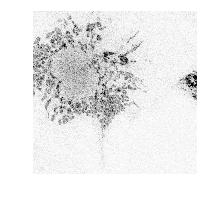

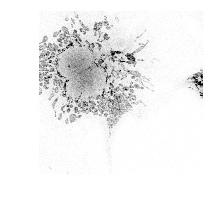

In [8]:
show_image(train_ds[0][0]), show_image(train_ds[0][1])

In [9]:
class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feats))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x
        return res
    
class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feats))

                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))

        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feats))

            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [10]:
n_feats = 64
kernel_size =3
n_colors = 1
res_scale = 1
act = 'relu'
n_resblocks = 16

def conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,
                     padding=(kernel_size//2), bias=bias)


def head():
    return [conv(1, n_feats, kernel_size)]

def body():
    body_layers = [
        ResBlock(conv, n_feats, kernel_size, res_scale=res_scale) 
        for _ in range(n_resblocks)
    ]
    body_layers.append(conv(n_feats, n_feats, kernel_size))
    return body_layers

def tail(scale):
    layers = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)
    ]
    return layers

class EDSR(nn.Module):
    def __init__(self, scale):
        super(EDSR,self).__init__()
        self.head = nn.Sequential(*head())
        self.body = nn.Sequential(*body())
        self.tail = nn.Sequential(*tail(scale))
        
    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res += x
        x = self.tail(res)
        return x
    

In [11]:
model = nn.DataParallel(EDSR(4))

In [12]:
loss = nn.L1Loss()

In [13]:
learn = Learner(data, model.cuda(), loss_func=loss)

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss
1,0.066697,0.075831
2,1140.407349,147.097794
3,149.086380,0.943184


In [14]:
learn.fit(1)

Total time: 01:51
epoch  train_loss  valid_loss
1      1.570406    0.054930    (01:51)

